# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Person 1
- Person 2
- Person 3

## Imports

In [ ]:
from typing import Dict, Tuple, TypeVar, Callable
from rl.markov_decision_process import FiniteMarkovDecisionProcess, StateActionMapping
from rl.distribution import Categorical, Constant
from rl.dynamic_programming import policy_iteration
from rl.function_approx import FunctionApprox
from rl.approximate_dynamic_programming import value_iteration_finite
from rl.function_approx import Tabular
from rl.policy import FinitePolicy, Policy
import numpy as np

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [66]:
GridState = Tuple[int, int]
GridAction = str

S = TypeVar('S')
A = TypeVar('A')

class SimpleGridWorld(FiniteMarkovDecisionProcess[GridState, GridAction]):
    def __init__(self, grid_size: Tuple[int, int]):
        self.grid_size = grid_size
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> StateActionMapping[GridState, GridAction]:
        d: Dict[GridState, Dict[GridAction, Categorical[Tuple[GridState, float]]]] = {}
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                state: GridState = (i, j)
                is_terminal = i == self.grid_size[0] - 1 and j == self.grid_size[1] - 1
                if not is_terminal:
                    d[state] = {
                        'Up': Categorical({((max(i - 1, 0), j), 0.0): 1.0}),
                        'Down': Categorical({((min(i + 1, self.grid_size[0] - 1), j), 0.0): 1.0}),
                        'Left': Categorical({((i, max(j - 1, 0)), 0.0): 1.0}),
                        'Right': Categorical({((i, min(j + 1, self.grid_size[1] - 1)), 0.0): 1.0})
                    }
                # Adjust rewards for actions leading directly into the terminal state
                if (i, j) == (self.grid_size[0] - 2, self.grid_size[1] - 1):  # State above terminal
                    d[state]['Down'] = Categorical({((i + 1, j), 1.0): 1.0})
                if (i, j) == (self.grid_size[0] - 1, self.grid_size[1] - 2):  # State left of terminal
                    d[state]['Right'] = Categorical({((i, j + 1), 1.0): 1.0})
        return d

def approximate_policy_iteration(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float,
    tolerance: float = 1e-6
) -> Tuple[Policy[S, A], Tabular[S]]:
    initial_policy_map = {
        s: Categorical({a: 1.0 / len(mdp.actions(s)) for a in mdp.actions(s)})
        for s in mdp.non_terminal_states if len(mdp.actions(s)) > 0
    }
    policy = FinitePolicy(policy_map=initial_policy_map)
    value_function = Tabular()

    for k in range(1000):
        for state in mdp.non_terminal_states:
            if not mdp.actions(state):  # Skip if no actions available
                continue
            action_values = {action: mdp.step(state, action).expectation(
                lambda sr: sr[1] + gamma * value_function.evaluate([sr[0]]).item()
            ) for action in mdp.actions(state)}
            best_action_value = max(action_values.values())
            old_value = value_function.evaluate([state]).item()
            value_function = value_function.update([(state, best_action_value)])
        
        for state in mdp.non_terminal_states:
            if not mdp.actions(state):  # Skip if no actions available
                continue
            action_values = {action: mdp.step(state, action).expectation(
                lambda sr: sr[1] + gamma * value_function.evaluate([sr[0]]).item()
            ) for action in mdp.actions(state)}
            best_action = max(action_values, key=action_values.get)
            policy.policy_map[state] = Categorical({best_action: 1.0})

    return policy, value_function

# Instantiate the Simple Grid World MDP
simple_mdp = SimpleGridWorld(grid_size=(3, 3))
gamma = 0.9 # Discount factor

# Run Approximate Policy Iteration
policy_api, value_function_api = approximate_policy_iteration(simple_mdp, gamma)

print("API Value Function:")
for state in sorted(value_function_api.values_map.keys()):
    print(f"State {state}: {value_function_api.values_map[state]:.2f}")

print("\n")
print(policy_api)

API Value Function:
State NonTerminal(state=(0, 0)): 0.70
State NonTerminal(state=(0, 1)): 0.80
State NonTerminal(state=(0, 2)): 0.90
State NonTerminal(state=(1, 0)): 0.80
State NonTerminal(state=(1, 1)): 0.90
State NonTerminal(state=(1, 2)): 1.00
State NonTerminal(state=(2, 0)): 0.90
State NonTerminal(state=(2, 1)): 1.00


For State NonTerminal(state=(0, 0)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(0, 1)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(0, 2)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(1, 0)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(1, 1)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(1, 2)):
  Do Action Down with Probability 1.000
For State NonTerminal(state=(2, 0)):
  Do Action Right with Probability 1.000
For State NonTerminal(state=(2, 1)):
  Do Action Right with Probability 1.000



In [89]:
# Ensuring that *Approximate Policy Iteration* produces the same result as Approximate Value Iteration

# Instantiate the Simple Grid World MDP
simple_mdp = SimpleGridWorld(grid_size=(3, 3))
gamma = 0.9 # Discount factor

ValueFunctionApprox = FunctionApprox[NonTerminal[S]]
initial_value_function = Tabular()

# Run Approximate Policy Iteration
value_iter = value_iteration_finite(simple_mdp, gamma, initial_value_function)

for _ in range(1000):
    value_function = next(value_iter)

print(value_function.values_map)

# Note that the results are the same as for our implementation of policy iteration, thus we have verified the correctness of our implementation

{NonTerminal(state=(0, 0)): 0.7029758937308568, NonTerminal(state=(0, 1)): 0.8031215109246886, NonTerminal(state=(0, 2)): 0.8990990990990989, NonTerminal(state=(1, 0)): 0.8031215109246886, NonTerminal(state=(1, 1)): 0.8990990990990989, NonTerminal(state=(1, 2)): 1.0, NonTerminal(state=(2, 0)): 0.8990990990990989, NonTerminal(state=(2, 1)): 1.0}


In [65]:
# Ensuring that *Approximate Policy Iteration* produces the same result as prior implementation of Policy Iteration

# Instantiate the Simple Grid World MDP
simple_mdp = SimpleGridWorld(grid_size=(3, 3))
gamma = 0.9 # Discount factor

# Run Approximate Policy Iteration
policy_iter = policy_iteration(simple_mdp, gamma)

value_function, policy = next(policy_iter)

for _ in range(1000):
    value_function, policy = next(policy_iter)
print("Value Function:")
for state, value in value_function.items():
    print(f"State {state}: {value:.2f}")
print("\nPolicy:")
for state, action_prob in policy.policy_map.items():
    print(f"State {state}: {action_prob}")
print("\n---\n")

# Note that the results are the same as for our implementation of policy iteration, thus we have verified the correctness of our implementation

Value Function:
State NonTerminal(state=(0, 0)): 0.73
State NonTerminal(state=(0, 1)): 0.81
State NonTerminal(state=(0, 2)): 0.90
State NonTerminal(state=(1, 0)): 0.81
State NonTerminal(state=(1, 1)): 0.90
State NonTerminal(state=(1, 2)): 1.00
State NonTerminal(state=(2, 0)): 0.90
State NonTerminal(state=(2, 1)): 1.00

Policy:
State (0, 0): Constant(value='Down')
State (0, 1): Constant(value='Down')
State (0, 2): Constant(value='Down')
State (1, 0): Constant(value='Down')
State (1, 1): Constant(value='Down')
State (1, 2): Constant(value='Down')
State (2, 0): Constant(value='Right')
State (2, 1): Constant(value='Right')

---



## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

$$
\begin{align*}
&\text{Expected utility: } E[U(x)] = E\left[x - \frac{\alpha x^2}{2}\right] = E[x] - \frac{\alpha}{2} E[x^2] = E[x] - \frac{\alpha}{2} \left(E[x]^2 + \text{Var}[x]\right) = \mu - \frac{\alpha}{2} \left(\mu^2 + \sigma^2\right) \\
&\text{Certainty equivalent is } x_{CE} = U^{-1}(E[U(x)]) = U^{-1}\left(\mu - \frac{\alpha}{2} \left(\mu^2 + \sigma^2\right)\right). \\
&\text{To find the inverse, we need to solve the quadratic equation: } \\
&x - \frac{\alpha x^2}{2} = \mu - \frac{\alpha}{2} \left(\mu^2 + \sigma^2\right). \\
&\text{Solving for } x\text{, we get that } \\
&x_{CE} = \frac{1 + \sqrt{(\alpha \mu - 1)^2 + \alpha^2 \sigma^2}}{\alpha}. \\
&\text{Finally, the absolute risk premium is } \pi_{A} = E[x] - x_{CE} = \mu - \frac{1 + \sqrt{(\alpha \mu - 1)^2 + \alpha^2 \sigma^2}}{\alpha}. \\
&\text{If we invested } z \text{ into a risky asset, then next year we will get } zx \text{ where } x \sim N(\mu, \sigma^2). \\
&\text{By investing } 10^6 - z \text{ in the riskless asset, next year we are going to get } (10^6 - z) \cdot r. \\
&\text{Thus, our payoff at } t=1, p = zx + (10^6 - z)r. \\
&\text{Our goal is to maximize } E[U(p)] = E[p] - \frac{\alpha \cdot E[p^2]}{2}. \\
&\text{Note that } p \text{ is scaled and shifted normal distribution. Thus } p \sim N(\mu z + (10^6 - z) \cdot r, \sigma^2 z^2). \\
&\text{And thus, } E[U(p)] = \mu z + (10^6 - z) \cdot r - \frac{\alpha}{2} ((\mu z + (10^6 - z) \cdot r)^2 + \sigma^2 z^2). \\
&\text{We want to maximize it with respect to } z. \\
&\text{The optimal choice of } z^* = \frac{10^6 \alpha r^2 - 10^6 \alpha r \mu - r + \mu}{\alpha ((r - \mu)^2 + \sigma^2)}. \\
&\text{In order to plot this solution against the value of alpha we choose } r = 1.05, \mu = 1.1, \text{ and } \sigma = 0.07. \\
&\text{We observe that as risk aversion factor increases, we optimally invest less into risky assets which agrees with the intuition.}
\end{align*}
$$

/var/folders/7d/zmv64w5j59v7k2lvs4f1n3vc0000gn/T/ipykernel_34503/2274682514.py:7: RuntimeWarning: divide by zero encountered in divide
  return numerator / denominator


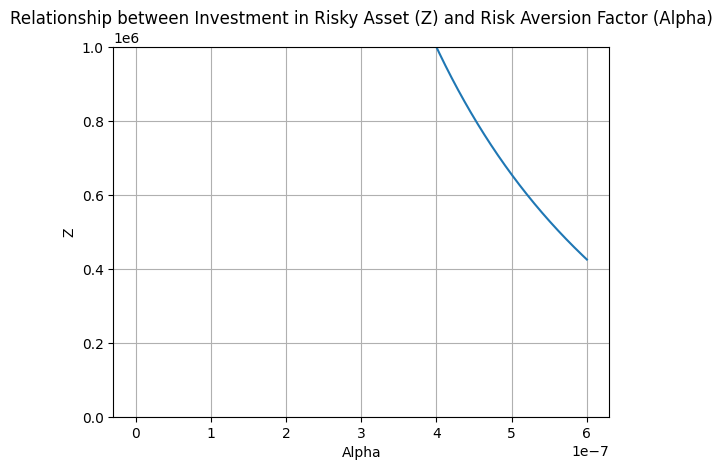

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def function(alpha):
    numerator = (10**6 * alpha * 1.05**2 - 10**6 * alpha * 1.05 * 1.1 - 1.05 + 1.1)
    denominator = alpha * ((1.1 - 1.05)**2 + 0.07)
    return numerator / denominator
alpha_values = np.linspace(0, 6e-7, 1000)
z_values = function(alpha_values)
plt.plot(alpha_values, z_values)
plt.title('Relationship between Investment in Risky Asset (Z) and Risk Aversion Factor (Alpha)')
plt.xlabel('Alpha')
plt.ylabel('Z')
plt.ylim(0, 1e6)  
plt.grid(True)
plt.show()

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


a) 

The first outcome for wealth: 

$(1-f) W_0 + f  W_0  (1 + \alpha) = W_0 (1 + f \alpha)$

The second outcome for wealth: 

$(1-f) W_0 + f  W_0  (1 - \beta) = W_0 (1 - f \beta)$



b) 

The first outcome for log W: 

$log (W_0) + log(1+f\alpha)$

The second outcome for log W: 

$log (W_0) + log(1-f\beta)$


c)
\begin{align*}
E[log(W)] &= p[log(W_0) + log(1+f\alpha)] + (1-p)[log(W_0) + log(1-f\beta)] \\
&= p [log(1+f\alpha)] + (1-p) [log(1-f\beta)] + log(W_0)
\end{align*}

d)
\begin{align*}
\frac{d}{df} E[log(W)] &= \frac{p\alpha}{1+f\alpha} + \frac{(p-1)\beta}{1-f\beta} \\
\end{align*}

e)
\begin{align*}
0 &= \frac{p\alpha}{1+f\alpha} + \frac{(p-1)\beta}{1-f\beta} \\
f \alpha (1-p)\beta + f p \alpha \beta &= (p-1)\beta + p\alpha \\
f &= \frac{p\beta + p\alpha - \beta}{\alpha \beta} \\
f &= \frac{p}{\alpha} + \frac{p}{\beta} - \frac{1}{\alpha} \\
f^* &= \frac{p}{\beta} - \frac{q}{\alpha}
\end{align*}

Verifying that the above equation is a maxima and not a minima we take the second derivative:

\begin{align*}
\frac{d}{df^2} E[log(W)] &= -\frac{p\alpha^2}{(1+f\alpha)^2} + \frac{\beta^2(p-1)}{(1-f\beta)^2}\\
\text{Evaluating this at the value of $f^*$ we found above:} \\ 
&= -\frac{p\alpha^2}{(1+(\frac{p}{\beta} - \frac{q}{\alpha})\alpha)^2} + \frac{\beta^2(p-1)}{(1-(\frac{p}{\beta} - \frac{q}{\alpha})\beta)^2} \\
&= - [\frac{p\alpha^2}{(1+(\frac{p}{\beta} + \frac{q}{\alpha})\alpha)^2} + \frac{q\beta^2}{(1-(\frac{p}{\beta} - \frac{q}{\alpha})\beta)^2}] \\
\end{align*}
Note that all terms in the numerators of the above two fractions is positive, and the denominators are positive since they are squared. Thus, the second derivative of $E[log(W)]$ at $f^*$ is always a negative value, and the value for $f^*$ we found must be a maxima.

f)

It makes intuitive sense that the formula for $f^*$ would have a positive relationship with p and negative one with q, as if we are more likely to win, the bet is safer, and we would feel comfortable investing more of our assets in that investment. It also makes sense that the larger the amount we risk losing ($\beta$), the less of a fraction of our wealth we would want to invest, and the more we have to win, ($\alpha$), the less we would worry about our risk of losing (q).

## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.